In [1]:
import dill
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score

warnings.filterwarnings('ignore')

# Data Preparation

## Загрузка данных

In [2]:
file_path = 'data/main_data.csv'
data = pd.read_csv(file_path, sep=';', encoding='utf_8_sig')
data.head()

,тип убытка,Номер убытка,Номер претензии,Дата события,Время ДТП,Место ДТП,Вид извещения о событии,Характер события,Оформлено сотрудниками ГИБДД,Адрес ДТП: Страна,...,Риск,Объект,Основание для претензии,Характер ущерба,Форма воозмещения,Основание для регресса,Дата предотсавления полного пакета документов,сумма,проверка,мошенник
0,У,У-000-01799744/16,У-000-01799744/16/3,20.06.2012,13:00:00,Автомагистраль,Заявление,ДТП с участием 2-х ТС с пострадавшими,ДА,Россия,...,Риски ОСАГО,Man TGA,Судебное решение,Смерть в результате ДТП,Денежная,NaN,NaN,12 500,Да,0
1,У,У-000-01799744/16,У-000-01799744/16/1,20.06.2012,13:00:00,Автомагистраль,Заявление,ДТП с участием 2-х ТС с пострадавшими,ДА,Россия,...,Риски ОСАГО,Man TGA,Судебное решение,Смерть в результате ДТП,Денежная,NaN,NaN,12 500,Да,0
2,У,У-000-01799744/16,У-000-01799744/16/2,20.06.2012,13:00:00,Автомагистраль,Заявление,ДТП с участием 2-х ТС с пострадавшими,ДА,Россия,...,Риски ОСАГО,Man TGA,Заявление от потерпевшего,Прочие повреждения,Денежная,NaN,19.10.2016,120 000,Да,0
3,ПВУ,ПВУ-991-077356/15,ПВУ-991-077356/15/1,17.03.2013,10:10:00,В пределах дорог (кроме автомагистралей),Заявление,ДТП с участием 2-х ТС без пострадавших,ДА,Россия,...,Риски ОСАГО,Porsche Cayenne S <K438KH177>,Заявление от потерпевшего,Прочие повреждения,NaN,NaN,01.04.2015,33 788,NaN,NaN
4,У,У-991-01781532/16,У-991-01781532/16/1,26.03.2013,18:00:00,В пределах дорог (кроме автомагистралей),Заказное письмо,ДТП с участием более 2-х ТС с пострадавшими,ДА,Россия,...,Риски ОСАГО,Chevrolet Niva,Заявление от потерпевшего,Прочие повреждения,Денежная,NaN,18.03.2016,120 000,Да,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14491 entries, 0 to 14490
Data columns (total 22 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   тип убытка                                     14491 non-null  object
 1   Номер убытка                                   14491 non-null  object
 2   Номер претензии                                14491 non-null  object
 3   Дата события                                   14491 non-null  object
 4   Время ДТП                                      14491 non-null  object
 5   Место ДТП                                      14491 non-null  object
 6   Вид извещения о событии                        14491 non-null  object
 7   Характер события                               14491 non-null  object
 8   Оформлено сотрудниками ГИБДД                   14491 non-null  object
 9   Адрес ДТП: Страна                              14491 non-null

In [4]:
print(f'Размерность датасета: {data.shape}')

Размерность датасета: (14491, 22)


In [5]:
# Оставим только размеченные данные
labeled_data = data.dropna(subset=['проверка'])
labeled_data.drop(columns=['проверка'], inplace=True)
print(f'Размерность размеченного датасета: {labeled_data.shape}')

Размерность размеченного датасета: (6434, 21)


## Преобразование типов данных

In [6]:
# Преобразуем сумму к числовому формату
labeled_data['сумма'] = labeled_data['сумма'].str.replace(' ', '').astype(float)

In [7]:
# Преобразум данные с датами в формат datetime
date_feats = [
    'Дата события',
    'Дата регистрации претензии',
    'Дата предотсавления полного пакета документов'
]

for dfeat in date_feats:
    labeled_data[dfeat] = pd.to_datetime(labeled_data[dfeat])

In [8]:
# От признака Время ДТП оставим только часы
labeled_data['Время ДТП'] = labeled_data['Время ДТП'].apply(lambda d: d.split(':')[0]).astype(int)

In [9]:
# Вместо признаков с дамами создадим признаки отвечающие за временные интервалы между ними
labeled_data['Количество дней между событием и регистрацией'] = (labeled_data['Дата регистрации претензии'] - labeled_data['Дата события']).dt.days
labeled_data['Количество дней между событием и предоставлением документов'] = (labeled_data['Дата предотсавления полного пакета документов'] - labeled_data['Дата события']).dt.days
labeled_data['Количество дней между регистрацией и предоставлением документов'] = (labeled_data['Дата предотсавления полного пакета документов'] - labeled_data['Дата регистрации претензии']).dt.days

labeled_data.drop(columns=date_feats, inplace=True)

In [10]:
print('Итоговые типы данных:')
labeled_data.dtypes

Итоговые типы данных:


тип убытка                                                          object
Номер убытка                                                        object
Номер претензии                                                     object
Время ДТП                                                            int32
Место ДТП                                                           object
Вид извещения о событии                                             object
Характер события                                                    object
Оформлено сотрудниками ГИБДД                                        object
Адрес ДТП: Страна                                                   object
Договор                                                             object
Риск                                                                object
Объект                                                              object
Основание для претензии                                             object
Характер ущерба          

## Обработка пропусков

In [11]:
print(f'Процентное число пропусков в признаках:')
labeled_data.isna().sum()/len(labeled_data)*100

Процентное число пропусков в признаках:


тип убытка                                                          0.000000
Номер убытка                                                        0.000000
Номер претензии                                                     0.000000
Время ДТП                                                           0.000000
Место ДТП                                                           0.000000
Вид извещения о событии                                             0.000000
Характер события                                                    0.000000
Оформлено сотрудниками ГИБДД                                        0.000000
Адрес ДТП: Страна                                                   0.000000
Договор                                                             0.000000
Риск                                                                0.000000
Объект                                                              0.000000
Основание для претензии                                             0.046627

In [12]:
# В признаке "Основание для регресса" слишком много пропусков, удалим этот столбец
labeled_data.drop(columns=["Основание для регресса"], inplace=True)

### Обработка пропусков в категориальных данных

In [13]:
cat_feat_miss = [
    'Основание для претензии',
    'Характер ущерба',
    'Форма воозмещения',
]

labeled_data[cat_feat_miss].describe()

,Основание для претензии,Характер ущерба,Форма воозмещения
count,6431,6429,5141
unique,7,18,2
top,Заявление от потерпевшего,Прочие повреждения,Денежная
freq,5703,5691,5121


In [14]:
# Заполним пропуски самым частым значением
labeled_data[cat_feat_miss] = SimpleImputer(strategy='most_frequent').fit_transform(labeled_data[cat_feat_miss])

### Обработка пропусков в числовых данных

In [15]:
num_feat_miss = [
    'сумма',
    'Количество дней между событием и предоставлением документов',
    'Количество дней между регистрацией и предоставлением документов'
]

labeled_data[num_feat_miss].describe()

,сумма,Количество дней между событием и предоставлением документов,Количество дней между регистрацией и предоставлением документов
count,5604.00000,4168.000000,4168.000000
mean,165794.51606,58.246161,8.242802
std,132528.83245,169.460311,102.795022
min,1.00000,-334.000000,-333.000000
25%,50000.00000,-11.000000,0.000000
50%,121010.50000,28.000000,1.000000
75%,268523.50000,113.000000,20.000000
max,831840.00000,1582.000000,569.000000


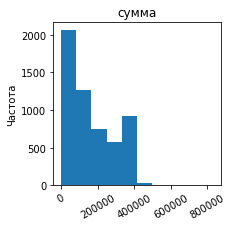

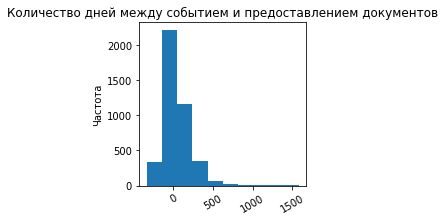

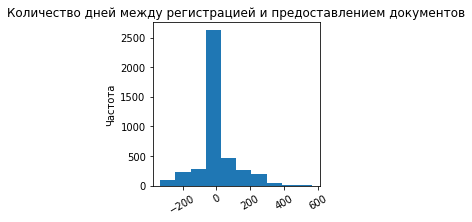

In [16]:
for nfeat in num_feat_miss:
    plt.figure(figsize=(3, 3))
    plt.hist(labeled_data[nfeat])
    plt.title(nfeat)
    plt.ylabel('Частота')
    plt.xticks(rotation=30)
    plt.show()

In [17]:
# Заполним пропуски медианным значением
labeled_data[num_feat_miss] = SimpleImputer(strategy='median').fit_transform(labeled_data[num_feat_miss])

## Анализ категориальных признаков

In [18]:
pd.DataFrame(labeled_data.select_dtypes('object').nunique(), columns=['число уникальных категорий'])

,число уникальных категорий
тип убытка,2
Номер убытка,3847
Номер претензии,6422
Место ДТП,10
Вид извещения о событии,5
Характер события,14
Оформлено сотрудниками ГИБДД,2
Адрес ДТП: Страна,1
Договор,3668
Риск,1


1. Признак "Номер претензии" содержит столько же уникальных категорий, сколько и объектов в датасете
2. Признак "Адрес ДТП: Страна" содержит только одну категорию.
3. Признак "Риск" содержит только одну категорию
4. В целевом признаке "мошенник" 3 категории (ожидалось 2)

In [19]:
labeled_data.drop(columns=['Номер претензии', 'Адрес ДТП: Страна', 'Риск'], inplace=True)

print(f'Уникальные категории в целевой переменной: {labeled_data["мошенник"].unique()}')

Уникальные категории в целевой переменной: ['0' 'Да' 'да']


In [20]:
# Переведем целевой признак в классы 0 (не мошенник) и 1 (мошенник)
labeled_data['мошенник'].replace({'0': 0, 'Да': 1, 'да': 1}, inplace=True)

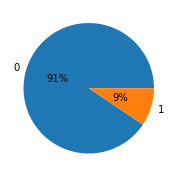

In [21]:
# Посмотрим на распределение целевого признака
d = labeled_data['мошенник'].value_counts()
plt.figure(figsize=(3,3))
plt.pie(d, labels=d.index, autopct='%1.0f%%', pctdistance=0.5)
plt.show()

***Классы несбалансированны***

# Modeling

## Подготовка данных на вход модели

In [22]:
# Разбиваем на тренировочную и тестовую выборки
X = labeled_data.drop(columns=['мошенник'])
y = labeled_data['мошенник']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [23]:
# Понадобится при подборе гиперпараметров модели
my_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [24]:
# Создаем препроцессор для предобработки признаков
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), make_column_selector(dtype_include='object')),
    ('num', StandardScaler(), make_column_selector(dtype_include=[int, float]))
])

***Для моделей машинного обучения будет произведен тюнинг гиперпараметров, при этом в качестве отслеживаемой метрики будет использоваться roc_auc_score, так как она не зависит от порога для вероятности принадлежности объекта к положительному классу. Сам порог в дальнейшем будет подбираться так, чтобы recall был выше 0.8, а precision был максимальным***

In [25]:
pipes = []
best_treshholds = []
target_recall = 0.8

In [26]:
def get_metrics(model, X_train, X_test, y_train, y_test):
    data = {
        'train':[
            roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
            recall_score(y_train, model.predict(X_train)),
            precision_score(y_train, model.predict(X_train)),
            accuracy_score(y_train, model.predict(X_train))
        ],
        'test':[
            roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
            recall_score(y_test, model.predict(X_test)),
            precision_score(y_test, model.predict(X_test)),
            accuracy_score(y_test, model.predict(X_test))
        ]
    }
    return pd.DataFrame(data, index=['roc_auc', 'recall', 'precision', 'accuracy'])

## Логистическая регрессия

In [27]:
logreg_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight='balanced', random_state=42))
])

params = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.01, 0.1, 1, 2],
    'model__solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'model__max_iter': [100, 200, 300]
}

logreg_grid = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=params,
    scoring='roc_auc',
    cv=my_cv
)

logreg_grid.fit(X_train, y_train)
best_logreg_pipe = logreg_grid.best_estimator_
print(f'Лучашя модель: {best_logreg_pipe.named_steps["model"]}')

Лучашя модель: LogisticRegression(C=2, class_weight='balanced', random_state=42,
                   solver='liblinear')


In [28]:
print('Метрики при стандартном пороге')
best_logreg_pipe.fit(X_train, y_train)
pipes.append(best_logreg_pipe)

get_metrics(best_logreg_pipe, X_train, X_test, y_train, y_test)

Метрики при стандартном пороге


,train,test
roc_auc,1.000000,0.897772
recall,1.000000,0.714286
precision,0.979215,0.884354
accuracy,0.998001,0.964267


## Модель билижайших соседей

In [29]:
knn_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier())
])

params = {
    'model__n_neighbors': np.arange(3, 21),
    'model__weights': ['uniform', 'distance']
}

knn_grid = GridSearchCV(
    estimator=knn_pipe,
    param_grid=params,
    scoring='roc_auc',
    cv=my_cv,
)

knn_grid.fit(X_train, y_train)
best_knn_pipe = knn_grid.best_estimator_
print(f'Лучашя модель: {best_knn_pipe.named_steps["model"]}')

Лучашя модель: KNeighborsClassifier(n_neighbors=9, weights='distance')


In [30]:
best_knn_pipe.fit(X_train, y_train)
pipes.append(best_knn_pipe)

get_metrics(best_knn_pipe, X_train, X_test, y_train, y_test)

,train,test
roc_auc,1.0,0.837953
recall,1.0,0.230769
precision,1.0,0.954545
accuracy,1.0,0.926463


## Метод опорных векторов

In [31]:
svc_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVC(probability=True, class_weight='balanced', random_state=42))
])

params = {
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'model__C': [0.01, 0.1, 1, 2]
}

svc_grid = GridSearchCV(
    estimator=svc_pipe,
    param_grid=params,
    scoring='roc_auc',
    cv=my_cv,
)

svc_grid.fit(X_train, y_train)
best_svc_pipe = svc_grid.best_estimator_
print(f'Лучашя модель: {best_svc_pipe.named_steps["model"]}')

Лучашя модель: SVC(C=2, class_weight='balanced', kernel='linear', probability=True,
    random_state=42)


In [32]:
best_svc_pipe.fit(X_train, y_train)
pipes.append(best_svc_pipe)

get_metrics(best_svc_pipe, X_train, X_test, y_train, y_test)

,train,test
roc_auc,1.0,0.928996
recall,1.0,0.703297
precision,1.0,0.934307
accuracy,1.0,0.967374


## Случайный лес

In [33]:
rfc_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(class_weight='balanced', random_state=42))
])

params = {
    'model__n_estimators': np.arange(50, 301, 50),
    'model__max_depth': np.arange(3, 11)
}

rfc_grid = GridSearchCV(
    estimator=rfc_pipe,
    param_grid=params,
    scoring='roc_auc',
    cv=my_cv,
)

rfc_grid.fit(X_train, y_train)
best_rfc_pipe = rfc_grid.best_estimator_
print(f'Лучашя модель: {best_rfc_pipe.named_steps["model"]}')

Лучашя модель: RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)


In [34]:
best_rfc_pipe.fit(X_train, y_train)
pipes.append(best_rfc_pipe)

get_metrics(best_rfc_pipe, X_train, X_test, y_train, y_test)

,train,test
roc_auc,0.914519,0.788791
recall,0.606132,0.373626
precision,0.665803,0.527132
accuracy,0.934266,0.909373


## XGBoost

In [35]:
pos_weight = (y_train==0).sum() / (y_train==1).sum()

In [36]:
xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(scale_pos_weight=pos_weight, random_state=42))
])

params = {
    'model__n_estimators': np.arange(50, 251, 50),
    'model__max_depth': np.arange(3, 11)
}

xgb_grid = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=params,
    scoring='roc_auc',
    cv=my_cv,
)

xgb_grid.fit(X_train, y_train)
best_xgb_pipe = xgb_grid.best_estimator_
print(f'Лучашя модель: {best_xgb_pipe.named_steps["model"]}')

Лучашя модель: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)


In [37]:
best_xgb_pipe.fit(X_train, y_train)
pipes.append(best_xgb_pipe)

get_metrics(best_xgb_pipe, X_train, X_test, y_train, y_test)

,train,test
roc_auc,0.999563,0.849316
recall,1.000000,0.604396
precision,0.860041,0.643275
accuracy,0.984677,0.931124


## Подбор порога для моделей

In [38]:
# Подберем порог для моделей на кросс-валидации, чтобы recall был выше 0.8 при максимальном precision
for pipe in pipes:
    model_thresholds = []
    for tr_index, val_index in my_cv.split(X_train, y_train):
        X_tr = X_train.iloc[tr_index]
        X_val = X_train.iloc[val_index]

        y_tr = y_train.iloc[tr_index]
        y_val = y_train.iloc[val_index]

        pipe.fit(X_tr, y_tr)
        y_val_pred_proba = pipe.predict_proba(X_val)[:, 1]

        thresholds = np.arange(0.1, 1, 0.01)
        model_threshold = 0
        best_recall = 0
        best_precision = 0
        for threshold in thresholds:
            y_pred = (y_val_pred_proba>=threshold).astype(int)
            recall = recall_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred)
            if recall >= target_recall and precision > best_precision:
                best_recall = recall
                best_precision = precision
                model_threshold = threshold
        model_thresholds.append(model_threshold)

    best_model_threshold = np.array(model_thresholds).mean()
    pipe.fit(X_train, y_train)
    y_pred = (pipe.predict_proba(X_test)[:, 1] >= best_model_threshold).astype(int)
    print('#'*20)
    print(f'Модель {type(pipe.named_steps["model"]).__name__}')
    print(f'При пороге {best_model_threshold}: recall={recall_score(y_test, y_pred)}, precision={precision_score(y_test, y_pred)}')
    best_treshholds.append(best_model_threshold)

####################
Модель LogisticRegression
При пороге 0.12: recall=0.8241758241758241, precision=0.21367521367521367
####################
Модель KNeighborsClassifier
При пороге 0.062: recall=0.8516483516483516, precision=0.15816326530612246
####################
Модель SVC
При пороге 0.0: recall=1.0, precision=0.09425168306576903
####################
Модель RandomForestClassifier
При пороге 0.45999999999999985: recall=0.9505494505494505, precision=0.11299804049640758
####################
Модель XGBClassifier
При пороге 0.07999999999999999: recall=0.9065934065934066, precision=0.12731481481481483


## Выбор итоговой модели

In [39]:
models = [type(pipe.named_steps['model']).__name__ for pipe in pipes]
roc_auc = []
accuracy = []
recall = []
precision = []
for pipe, threshold in zip(pipes, best_treshholds):
    y_pred_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > threshold).astype(int)
    roc_auc.append(roc_auc_score(y_test, y_pred_proba))
    accuracy.append(accuracy_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))

In [40]:
scoring_table = pd.DataFrame({
    'roc_auc': roc_auc,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall
}, index=models)

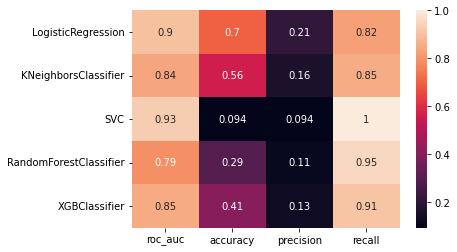

In [41]:
sns.heatmap(scoring_table, annot=True);

Модель, показывающая лучшие метрики для данной задачи - модель логистической регресии

# Pipeline

Перед поступлением данных на вход в модель с ними проиходили следующие преобразования:
1. Был удален признак "проверка" из-за неинформативности.
2. Признак "сумма" был приведен к числовому типу данных.
3. Признаки даты были преведы к типу данных datetime.
4. Признак "Время ДТП" был преобразован в часы.
5. Из признаков дат были получены новые - числа дней между датами.
6. Были удалены признаки дат.
7. Был удален признак "Основание для регресса", из-за большого числа пропусков
8. Пропуски в признаках "Основание для претензии", "Характер ущерба", "Форма воозмещения" были заполнены самым частым значением.
9. Пропуски в признаках "сумма", "Количество дней между событием и предоставлением документов", "Количество дней между регистрацией и предоставлением документов" были заполнены медианным значением.
10. Были удалены признаки "Номер претензии", "Адрес ДТП: Страна", "Риск" из-за их неинформативности.
11. Отсавшиеся категориальные признаки кодировались с помощью OneHotEncoding.
12. Оставшиеся числовые признаки кодировались с помощью StandardScaler


## Создание пайплайна

In [42]:
def change_dtypes(df_in):
    df = df_in.copy()
    df['сумма'] = df['сумма'].str.replace(' ', '').astype(float)
    date_feats = [
        'Дата события',
        'Дата регистрации претензии',
        'Дата предотсавления полного пакета документов'
    ]
    for dfeat in date_feats:
        df[dfeat] = pd.to_datetime(df[dfeat])
    return df

In [43]:
def generate_features(df_in):
    df = df_in.copy()
    df['Время ДТП'] = df['Время ДТП'].apply(lambda d: d.split(':')[0]).astype(int)
    df['Количество дней между событием и регистрацией'] = (df['Дата регистрации претензии'] - df['Дата события']).dt.days
    df['Количество дней между событием и предоставлением документов'] = (df['Дата предотсавления полного пакета документов'] - df['Дата события']).dt.days
    df['Количество дней между регистрацией и предоставлением документов'] = (df['Дата предотсавления полного пакета документов'] - df['Дата регистрации претензии']).dt.days
    return df

In [44]:
def drop_fetures(df_in):
    df = df_in.copy()
    df.drop(columns=[
        'проверка',
        'Дата события',
        'Дата регистрации претензии',
        'Дата предотсавления полного пакета документов',
        'Основание для регресса',
        'Номер претензии',
        'Адрес ДТП: Страна',
        'Риск'
    ], inplace=True)
    return df

In [45]:
num_preprocess = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('std', StandardScaler())
])

cat_preprocess = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

my_preprocessor = ColumnTransformer([
    ('num', num_preprocess, make_column_selector(dtype_include=[int, float])),
    ('cat', cat_preprocess, make_column_selector(dtype_include='object'))
])

In [46]:
model = LogisticRegression(C=2, class_weight='balanced', random_state=42, solver='liblinear')

In [47]:
final_pipeline = Pipeline([
    ('change_dtypes', FunctionTransformer(change_dtypes)),
    ('generate_features', FunctionTransformer(generate_features)),
    ('drop_fetures', FunctionTransformer(drop_fetures)),
    ('preprocess', my_preprocessor),
    ('estimator', model)
])

## Использование пайплайна

In [48]:
train_data = data[~data['мошенник'].isna()]
test_data = data[data['мошенник'].isna()]
train_data['мошенник'].replace({'0': 0, 'Да': 1, 'да': 1}, inplace=True)

In [49]:
X = train_data.drop(columns=['мошенник'])
y = train_data['мошенник']

test_data.drop(columns=['мошенник'], inplace=True)

In [50]:
final_pipeline.fit(X, y)

Pipeline(steps=[('change_dtypes',
                 FunctionTransformer(func=<function change_dtypes at 0x000001A1509BE9E0>)),
                ('generate_features',
                 FunctionTransformer(func=<function generate_features at 0x000001A1503C64D0>)),
                ('drop_fetures',
                 FunctionTransformer(func=<function drop_fetures at 0x000001A140A13C70>)),
                ('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(st...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A1408FB430>),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A1502E24D0>)])),
                ('estimator',
                 LogisticRegression(C=2, class_weight='balanced',
                                    random_state=42, solver='liblinear'))])

In [51]:
logreg_threshold = 0.12

In [52]:
objects = test_data.iloc[:2]
objects['мошенник'] = (final_pipeline.predict_log_proba(objects)[:, 1] >= logreg_threshold).astype(int)
objects

,тип убытка,Номер убытка,Номер претензии,Дата события,Время ДТП,Место ДТП,Вид извещения о событии,Характер события,Оформлено сотрудниками ГИБДД,Адрес ДТП: Страна,...,Риск,Объект,Основание для претензии,Характер ущерба,Форма воозмещения,Основание для регресса,Дата предотсавления полного пакета документов,сумма,проверка,мошенник
3,ПВУ,ПВУ-991-077356/15,ПВУ-991-077356/15/1,17.03.2013,10:10:00,В пределах дорог (кроме автомагистралей),Заявление,ДТП с участием 2-х ТС без пострадавших,ДА,Россия,...,Риски ОСАГО,Porsche Cayenne S <K438KH177>,Заявление от потерпевшего,Прочие повреждения,NaN,NaN,01.04.2015,33 788,NaN,0
5,ПВУ,ПВУ-991-079454/15,ПВУ-991-079454/15/3,27.03.2013,9:35:00,В пределах дорог (кроме автомагистралей),Претензия другой СК,ДТП с участием 2-х ТС без пострадавших,ДА,Россия,...,Риски ОСАГО,Toyota Corolla,Судебное решение,Прочие повреждения,Денежная,NaN,NaN,11 236,NaN,0


In [54]:
with open('best_pipe.pkl', 'wb') as file:
    dill.dump(final_pipeline, file)